# Exercise 3 -- Task 3(with a simple sample of task 1)

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers. This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1

* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function
 

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        # TODO: initialize network layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 2, 0), # set stride=2 -> 64 * 12 * 12
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 2, 0), # set stride=2 -> 64 * 12 * 12
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1, 0), # -> 64 * 24 * 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # use maxpool  -> 64 * 12 * 12
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

\Training ConvNet1...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307287
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.145794
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.128264
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.062271
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.161799
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.059538
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.023219
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.083802
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.025730
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.082042

Test set: Average loss: 0.0376, Accuracy: 9864/10000 (98.64%)



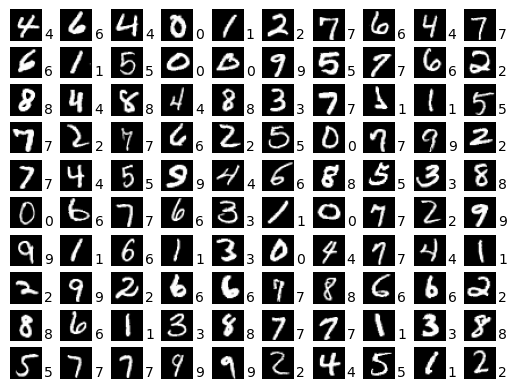

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023136
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.003563
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.031827
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.012931
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.016918
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.025319
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.063689
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.012287
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022922
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.009202

Test set: Average loss: 0.0308, Accuracy: 9903/10000 (99.03%)



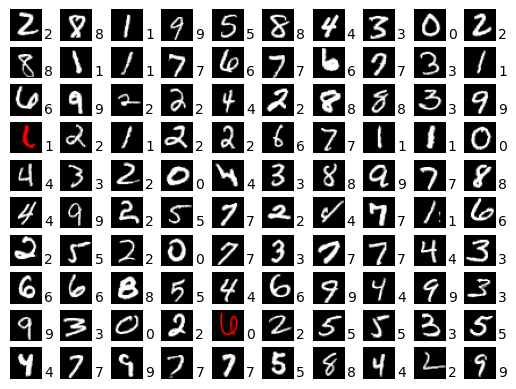

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.001402
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.000581
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001379
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.004501
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.002780
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000804
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.001949
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.000443
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.002037
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.070333

Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)



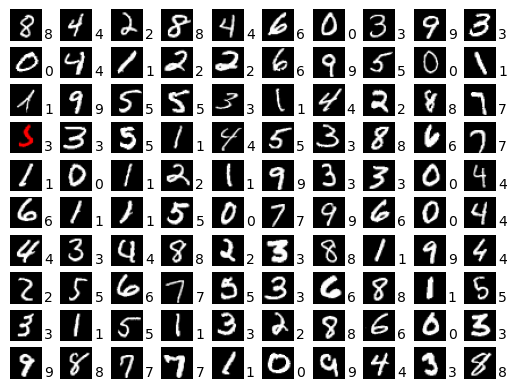

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002654
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.004963
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.022893
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.009380
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.013391
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000534
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.008856
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000521
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000097
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000118

Test set: Average loss: 0.0295, Accuracy: 9919/10000 (99.19%)



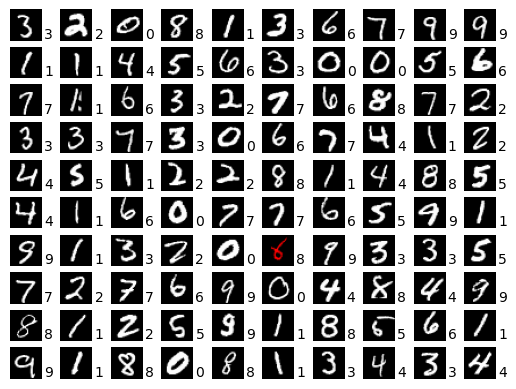

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001348
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000541
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001031
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000140
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000622
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000349
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000991
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.060442
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000019
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002780

Test set: Average loss: 0.0301, Accuracy: 9923/10000 (99.23%)



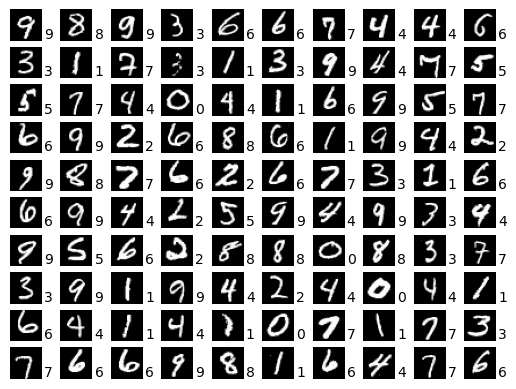

\Training ConvNet2...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.431263
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.145505
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.036741
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.038673
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.018142
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.043092
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014648
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.087676
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.078782
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.015868

Test set: Average loss: 0.0389, Accuracy: 9863/10000 (98.63%)



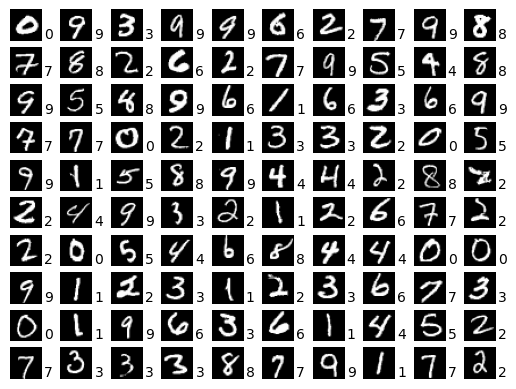

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.014668
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.006032
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.012480
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.053497
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025070
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.049781
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.004319
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.012999
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.087086
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.037958

Test set: Average loss: 0.0336, Accuracy: 9879/10000 (98.79%)



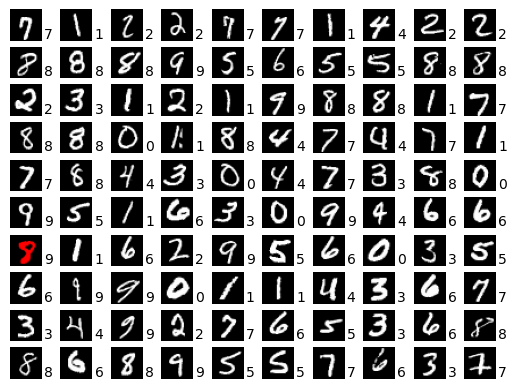

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027272
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.014628
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003017
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.012945
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.017168
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.017475
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.001574
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.005633
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.020568

Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)



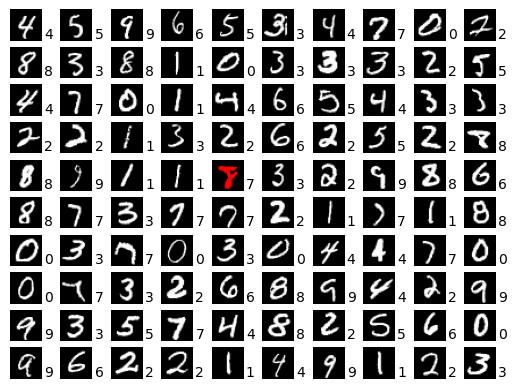

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002849
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000787
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.003076
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001564
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000137
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004611
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.010015
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001475
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001790
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000306

Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)



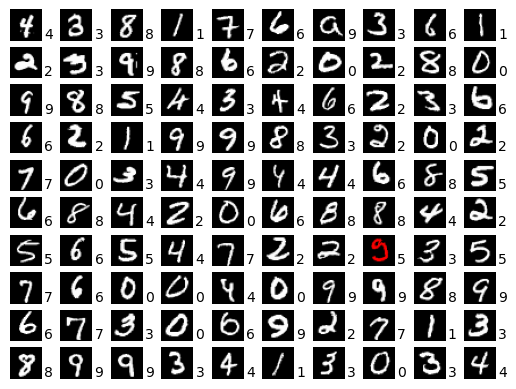

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000854
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002589
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.005808
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001655
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.002129
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.003459
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000274
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.008635
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000899
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001580

Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)



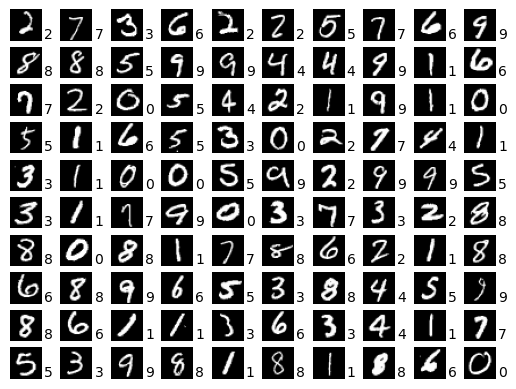

\Training ConvNet3...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.403399
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.072075
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.044281
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.155133
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.037853
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.028012
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.181373
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.068667
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.015034
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.012142

Test set: Average loss: 0.0341, Accuracy: 9885/10000 (98.85%)



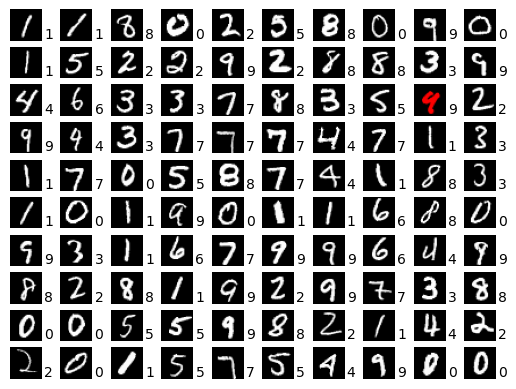

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003615
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.030020
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003623
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.006183
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.011508
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.005465
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.011112
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.011010
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.013440
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.039630

Test set: Average loss: 0.0327, Accuracy: 9885/10000 (98.85%)



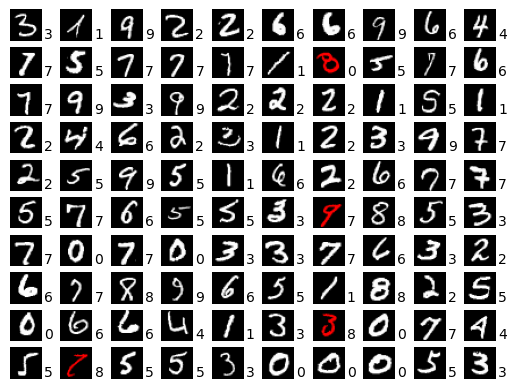

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.009214
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.003211
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.012839
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.001167
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.007929
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.133833
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003350
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.010431
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.011103
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.002297

Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)



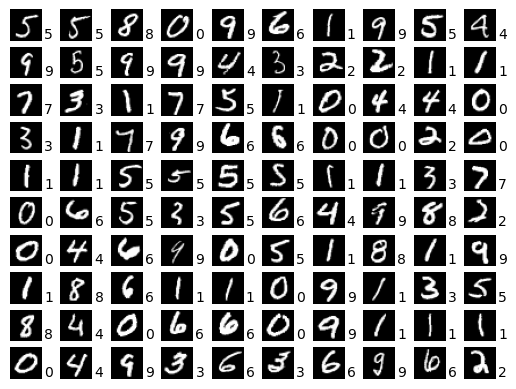

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001161
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001852
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.019729
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.051289
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.001280
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002197
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.006407
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.082328
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.004939
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.018696

Test set: Average loss: 0.0277, Accuracy: 9911/10000 (99.11%)



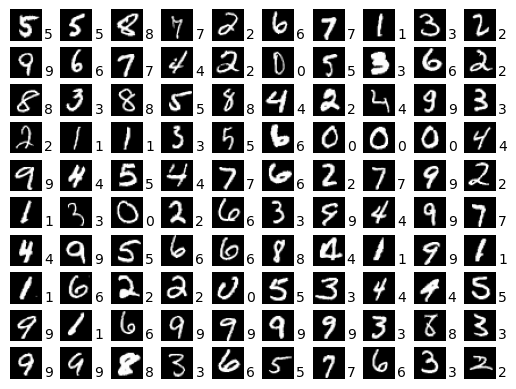

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000576
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000461
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001957
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001311
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.003636
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.007791
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.005186
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.006559
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.002719
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000512

Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)



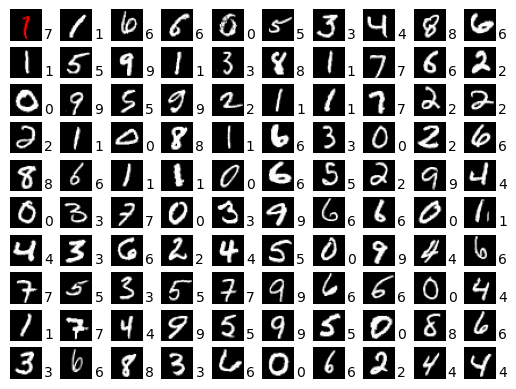

In [7]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 5
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

models = {
    "ConvNet1": ConvNet1(),
    "ConvNet2": ConvNet2(),
    "ConvNet3": ConvNet3()
}

for name, model in models.items():
    print(f"\nTraining {name}...\n")
    
    if use_cuda:
        model = model.cuda()
    
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
        validate(model, use_cuda, test_loader)
        scheduler.step()

    # Save model checkpoint
    torch.save(model.state_dict(), f"models/mnist/{name}_checkpoint.pt")

We can observe that the training effect does not necessarily get better as the network gets deeper. It is worth mentioning that the lowest test set loss, loss=0.0269, appeared on ConvNet2. Since the test set results are not as good as the training set results, it can be considered that more training epochs can be added. Due to computing power reasons, I only choose to train 5 epochs here. The overall loss and accuracy can already be acceptable.